In [319]:
#sudo apt-get install ffmpeg libavcodec-extra #in linux
#brew install ffmpeg #in lac allow super user too
#in windows use the website:https://github.com/jiaaro/pydub#installation
#pip install pydub
#pip install aubio 
# https://aubio.org/manual/latest/python_module.html

# How to run the program

- To run for a file, download the file into your local folder
- Make sure that all the required libraries are installed 
- Make sure that all the functions blocks are run.
- then run the function task with the filename as the argument.

In [321]:
import pydub
import numpy as np
import matplotlib.pyplot as plt
import aubio
import scipy
import warnings
warnings.filterwarnings("ignore")
values= {'happy':4,'sad':3,'angry':2,'neutral':1}

In [322]:
def load_file(file_name):
    audio = pydub.AudioSegment.from_mp3(file_name)
    signal = audio.get_array_of_samples()
    return audio,signal

In [323]:
def calculate_pitch(audio,signal):
    pitch_frame = []
    for i in range(0,len(signal),256):
        frame = np.array([float(x) for x in signal[i:i+256]],dtype=np.float32)
        Pitch = aubio.pitch("yin",2*len(frame),len(frame),audio.frame_rate)
        Pitch.set_unit("midi")
        Pitch.set_tolerance(0.8)
        pitch = Pitch(frame)[0]
        pitch_frame.append(pitch)
    pitch_frame = np.array(pitch_frame)
    return pitch_frame

In [324]:
# spectral features
def total_spectral(audio,signal):
    window = np.hanning(len(signal))
    signal = signal*window
    fft_spectrum = np.abs(np.fft.fft(signal))
    fft_spectrum = fft_spectrum[:len(fft_spectrum)//2]
    fft_freq = np.fft.fftfreq(len(signal),1.0/audio.frame_rate)
    fft_freq = fft_freq[:len(fft_freq)//2]
    spectral_centroid = np.sum(fft_freq*fft_spectrum)/np.sum(fft_spectrum)
    spectral_rolloff = fft_freq[np.argmax(np.cumsum(fft_spectrum)>0.85*np.sum(fft_spectrum))]
    peaks, _ = scipy.signal.find_peaks(fft_spectrum, prominence=np.mean(fft_spectrum))
    spectral_flux = np.sum(np.abs(np.diff(np.log(fft_spectrum[peaks]))))
    fft_freq = fft_freq.reshape(-1,1)
    spectr = {}
    spectr['centroid'] = spectral_centroid
    spectr['rolloff'] = spectral_rolloff
    spectr['flux'] = spectral_flux
    return spectr


In [325]:
def overall_spectral(audio,signal):
    spectral_features = []
    for i in range(0,len(signal),256):
        frame = np.array([float(x) for x in signal[i:i+256]],dtype=np.float32)
        frame = frame*np.hanning(len(frame))
        frame_fft_spectrum = np.abs(np.fft.fft(frame))
        frame_fft_spectrum = frame_fft_spectrum[:len(frame_fft_spectrum)//2]
        frame_fft_freq = np.fft.fftfreq(len(frame),1.0/audio.frame_rate)
        frame_fft_freq = frame_fft_freq[:len(frame_fft_freq)//2]
        frame_spectral_centroid = np.sum(frame_fft_freq*frame_fft_spectrum)/np.sum(frame_fft_spectrum)
        frame_spectral_rolloff = frame_fft_freq[np.argmax(np.cumsum(frame_fft_spectrum)>0.85*np.sum(frame_fft_spectrum))]
        frame_peaks, _ = scipy.signal.find_peaks(frame_fft_spectrum, prominence=np.mean(frame_fft_spectrum))
        frame_spectral_flux = np.sum(np.abs(np.diff(np.log(frame_fft_spectrum[frame_peaks]))))
        spectral_features.append((frame_spectral_centroid,frame_spectral_rolloff,frame_spectral_flux))
    spectral_features = np.array(spectral_features)
    return spectral_features

In [340]:
def classify(centroid,rolloff,flux,avg_pitch):
    if centroid < 4000 and rolloff > 4000 and flux < 650 and avg_pitch > 120:
        return 'happy'
    elif centroid < 4000 and rolloff < 8000 and flux < 650 and avg_pitch < 120:
        return 'sad'
    elif centroid > 3000 and rolloff > 5000 and flux > 650 and avg_pitch > 120:
        return 'angry'
    else:
        return 'neutral'

In [350]:
def classify_overall(pitch_frame,spectral):
    avg_pitch = np.sum(pitch_frame)/len(pitch_frame)
    # print(avg_pitch)
    # print(spectral)
    return classify(spectral['centroid'],spectral['rolloff'],spectral['flux'],avg_pitch)

In [351]:
def graph_emotion(pitch_frame,spectral_features):
    assert(len(pitch_frame) == len(spectral_features))
    sum = 0
    emotions = []
    for i in range(len(pitch_frame)):
        sum += pitch_frame[i]
        avg = sum/(i+1)
        emotions.append(classify(spectral_features[i][0],spectral_features[i][1],spectral_features[i][2],avg))
    emotions = list(map(lambda x:values[x],emotions))
    plt.plot(emotions)

In [352]:
def task(filename):
    audio,signal = load_file(filename)
    pitch_frame = calculate_pitch(audio,signal)
    spectral = total_spectral(audio,signal)
    print(classify_overall(pitch_frame,spectral))
    spectral_features = overall_spectral(audio,signal)
    graph_emotion(pitch_frame,spectral_features)

angry
angry
angry
angry


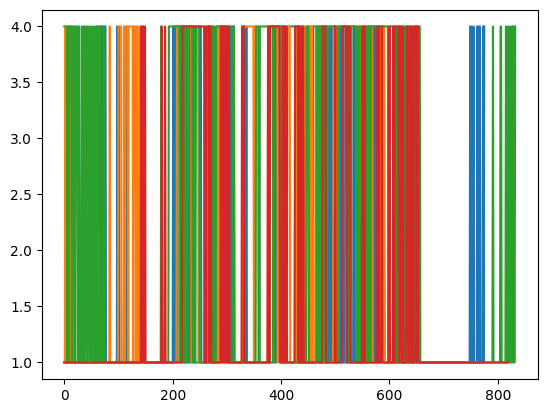

In [353]:
task('./03-01-05-02-02-01-01.mp3')
task('./03-01-05-02-01-01-01.mp3')
task('./03-01-05-02-02-02-01.mp3')
task('./03-01-05-02-01-02-01.mp3')


happy
happy
happy
happy


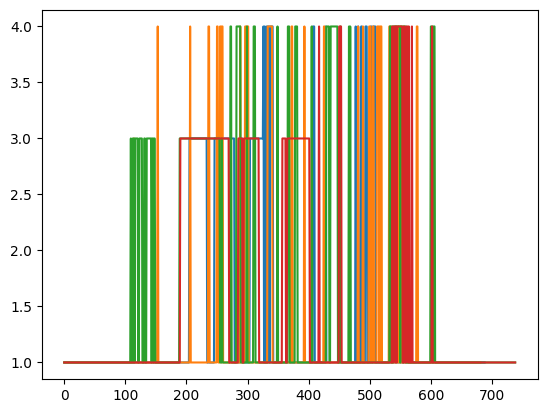

In [354]:
task('./03-01-03-02-01-01-01.mp3')
task('./03-01-03-02-01-02-01.mp3')
task('./03-01-03-02-02-01-01.mp3')
task('./03-01-03-02-02-02-01.mp3')

sad
sad
sad
sad


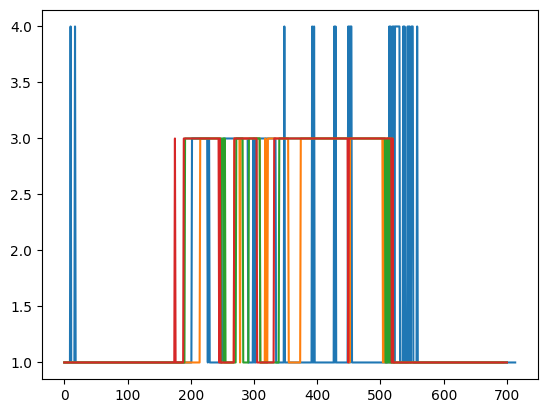

In [355]:
task('./03-01-04-02-01-01-01.mp3')
task('./03-01-04-02-01-02-01.mp3')
task('./03-01-04-02-02-01-01.mp3')
task('./03-01-04-02-02-02-01.mp3')